In [5]:
import pandas as pd

# Loading data from the uploaded file
data = pd.read_csv('gsw.csv')

# Data preprocessing
data['game_result'] = (data['pts'] > data['opp_pts']).astype(int)
data['game_location'] = data['game_location'].map({'@': 0, 'home': 1})
data['date_game'] = pd.to_datetime(data['date_game'], errors='coerce')
data['year'] = data['date_game'].dt.year
data['month'] = data['date_game'].dt.month
data['day'] = data['date_game'].dt.day

# Dropping unnecessary columns
data = data.drop(['date_game', 'opp_pts'], axis=1)
data = data.drop(['Team', 'x'], axis=1)

# Checking for any remaining NaN values and the overall structure
nan_check = data.isna().sum()
structure = data.dtypes

nan_check, structure



(game_season      0
 game_location    0
 opp_id           0
 game_result      0
 pts              0
 fg               0
 fga              0
 fg_pct           0
 fg3              0
 fg3a             0
 fg3_pct          0
 ft               0
 fta              0
 ft_pct           0
 orb              0
 trb              0
 ast              0
 stl              0
 blk              0
 tov              0
 pf               0
 opp_fg           0
 opp_fga          0
 opp_fg_pct       0
 opp_fg3          0
 opp_fg3a         0
 opp_fg3_pct      0
 opp_ft           0
 opp_fta          0
 opp_ft_pct       0
 opp_orb          0
 opp_trb          0
 opp_ast          0
 opp_stl          0
 opp_blk          0
 opp_tov          0
 opp_pf           0
 year             0
 month            0
 day              0
 dtype: int64,
 game_season        int64
 game_location      int64
 opp_id            object
 game_result        int64
 pts                int64
 fg                 int64
 fga                int64
 fg

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

# Defining the hyperparameter grid for GradientBoostingClassifier
gbc_params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}

# Splitting the dataset for model training
X = data.drop('game_result', axis=1)
y = data['game_result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# GridSearchCV for GradientBoostingClassifier
gbc_grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), gbc_params, cv=3)
gbc_grid_search.fit(X_train.select_dtypes(include='number'), y_train)  # Using only numerical columns
gbc_best_params = gbc_grid_search.best_params_

gbc_best_params



{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

In [7]:
from sklearn.tree import DecisionTreeClassifier

# Defining the hyperparameter grid for DecisionTreeClassifier
dtc_params = {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}

# GridSearchCV for DecisionTreeClassifier
dtc_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), dtc_params, cv=3)
dtc_grid_search.fit(X_train.select_dtypes(include='number'), y_train)  # Using only numerical columns

# Best parameters for DecisionTreeClassifier
dtc_best_params = dtc_grid_search.best_params_
dtc_best_params



{'max_depth': 10, 'min_samples_split': 10}

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Reloading and preprocessing the data since the environment was reset
data = pd.read_csv('gsw.csv')

data['game_result'] = (data['pts'] > data['opp_pts']).astype(int)
data['game_location'] = data['game_location'].map({'@': 0, 'home': 1})
data['date_game'] = pd.to_datetime(data['date_game'], errors='coerce')
data['year'] = data['date_game'].dt.year
data['month'] = data['date_game'].dt.month
data['day'] = data['date_game'].dt.day
data = data.drop(['date_game', 'opp_pts', 'Team', 'x'], axis=1, errors='ignore')

# Splitting the dataset
X = data.drop('game_result', axis=1)
y = data['game_result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a simpler model - Logistic Regression
simple_model = LogisticRegression(max_iter=1000)
simple_model.fit(X_train.select_dtypes(include='number'), y_train)  # Using only numerical columns

# Predicting with the simpler model
simple_y_pred = simple_model.predict(X_test.select_dtypes(include='number'))

# Calculating accuracy for the simpler model
simple_model_accuracy = accuracy_score(y_test, simple_y_pred)

# Preparing the complex model (Voting Classifier with Gradient Boosting and Decision Tree)
# Gradient Boosting Classifier best parameters
gbc_best_params = {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3}

# Decision Tree Classifier best parameters
dtc_best_params = {'max_depth': 10, 'min_samples_split': 2}

# Pipeline for preprocessing
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = [col for col in X.columns if col not in categorical_cols + ['game_result']]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ]
)

# Assembling the voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('gbc', GradientBoostingClassifier(**gbc_best_params, random_state=42)),
        ('dtc', DecisionTreeClassifier(**dtc_best_params, random_state=42))
    ], voting='hard')

# Complete pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', voting_clf)])

# Fitting the complex model
pipeline.fit(X_train, y_train)

# Predicting with the complex model
complex_y_pred = pipeline.predict(X_test)
complex_model_accuracy = accuracy_score(y_test, complex_y_pred)

simple_model_accuracy, complex_model_accuracy



/Users/arpanavvari/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.9942857142857143, 0.9028571428571428)

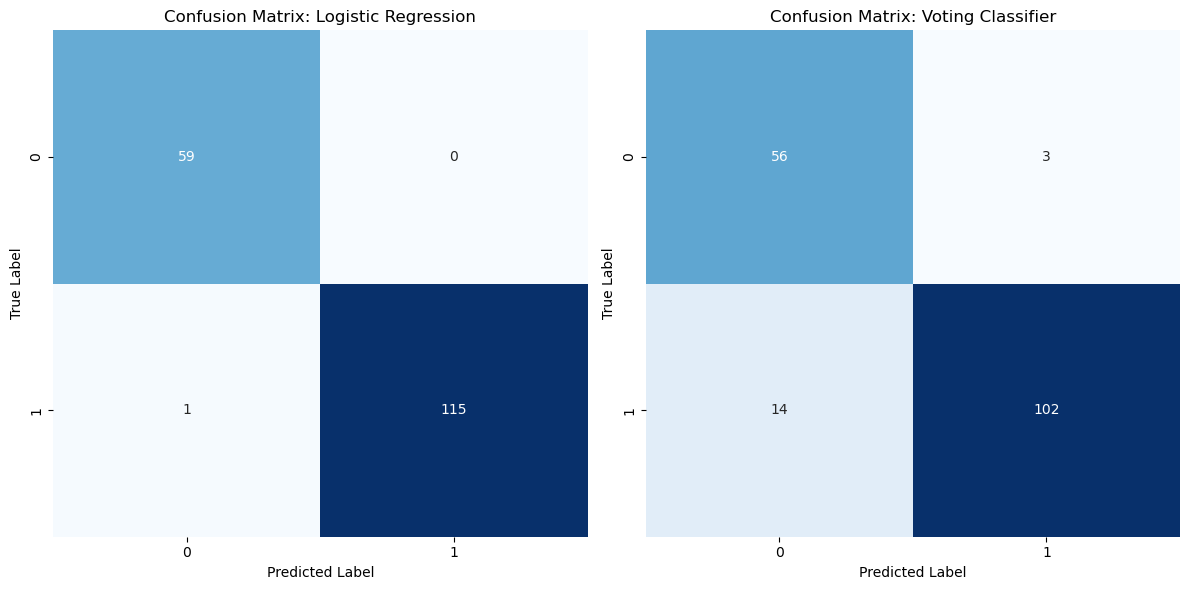

In [2]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculating confusion matrices for both models
cm_simple = confusion_matrix(y_test, simple_y_pred)
cm_complex = confusion_matrix(y_test, complex_y_pred)

# Plotting the confusion matrices
plt.figure(figsize=(12, 6))

# Simple Model
plt.subplot(1, 2, 1)
sns.heatmap(cm_simple, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Complex Model
plt.subplot(1, 2, 2)
sns.heatmap(cm_complex, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Voting Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

